In [ ]:
%%html
<marquee style='width: 100%; color: red;'><b><li style="font-size:75px;">Data Preparation</li></b></marquee>

## Read the data

Data is read in the form of .pkl files from the [directory](https://drive.google.com/drive/folders/1DXLnY2IFHQCfkV76UUxdUgCQxvxH4ojO?usp=sharing) where it is stored

In [15]:
# Libraries
import pandas as pd
import numpy as np
import os
import html
import re,string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

<div class="alert alert-block alert-danger">
<b>Data Load:</b> Used colab and given the directory for reading the ".pkl" file but you can specify your own "directory" too
</div>

In [3]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Go to the file created in Colab and specify your path
dir = '/content/drive/MyDrive/IMDB_Data'

**Note:** Used the uncleaned file for reading the data

In [ ]:
# Reading in proper format from our mentioned file
df_train = pd.read_pickle(dir + '/train.pkl')
df_test  = pd.read_pickle(dir + '/test.pkl')

## Data Cleaning

- For the purpose of data cleaning we use "regex" functions to get rid of unwanted chars using "linebreaks", "semicolons" and other special characters

- We retain the numerical characters though as it could be an important feature for tokenizing

In [ ]:
def clean_text(text):
    
    # Converting to string format first
    text = str(text)

    # Remove all HTML characters as it is a data from web
    text = re.sub('<.*?>', '', text)

    # Remove new line break
    text =  str(text).replace("\\", "")

    # Remove apestrophe
    text =  str(text).replace("'", "")

    # Remove "most annoying" line begin
    text = text[1:]

    # Consider only alphabets and numerics
    text = re.sub(r'[^A-Za-z0-9]+',' ',text)

    return text

```python
'''#### Alternative script ####
Basic Function to remove special characters and preprocess it primarily

'''
def clean_text(text): 

   # Remove all HTML characters as it is a data from web
    #text = re.sub('<.*?>', '', str(text))

   # Remove all the special characters
    text = re.sub(r'\W', ' ', str(text))

    # remove all single characters
    text= re.sub(r'\s+[a-zA-Z0-9]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # Converting to Lowercase
    text = text.lower()

    return text
```

In [ ]:
# Apply function on Text column of train and test
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text']  = df_test['Text'].apply(clean_text)


# Apply int function on Label column of train and test to get straight sentiments
df_train['Label'] = df_train['Label'].astype(int)
df_test['Label']  = df_test['Label'].astype(int)

In [ ]:
# Let's see a line
df_train['Text'][6]

'Okay you have Penelope Keith as Miss Herringbone Tweed B B E Backbone of England Shes killed off in the first scene thats right folks this show has no backbone Peter OToole as Ol Colonel Cricket from The First War and now the emblazered Lord of the Manor Joanna Lumley as the ensweatered Lady of the Manor 20 years younger than the colonel and 20 years past her own prime but still glamourous Brit spelling not mine enough to have a toy boy on the side Its alright they have Col Crickets full knowledge and consent they guy even comes round for Christmas Still shes considerate of the colonel enough to have said toy boy her own age what a gal David McCallum as said toy boy equally as pointlessly glamourous as his squeeze Pilcher couldnt come up with any cover for him within the story so she gave him a hush hush job at the Circus and finally Susan Hampshire as Miss Polonia Teacups Venerable Headmistress of the Venerable Girls Boarding School serving tea in her office with a dash of deep poign

 ## Feature Generation

1. We will generate features which will be helpful for modelling purpose as each feature space will correspond to some form of "represenatation learning"

2. The features generated here are are of broadly **three** types:
   - Numerical word vector and attribute count
   - POS dependency tag count
   - Sentiment attribute

3. Let's talk about them one by one



> **Numerical word vector and attribute count**: These word vectors represents the "character count" and "word count" in each text which would throw some information about the nature of texts. Additionally, the attribute count gives what was the semantic representation of the word when we labelled it as poitive or negative sentiment.



> **POS dependency tag count**: There are seven types type of Open class words for which features are generated which can be found in [universal POS tags](https://universaldependencies.org/docs/u/pos/). Generating count of these tags in the sentences lends some POS characteristics to the text.

> **Sentiment attribute**: This is a from of preemptive bias we provide in the form of better learning. The two global attributes used here are:

- **Polarity** : It refers to the type of sentiment in text. The value typically lies in the range between [-1, 1]

- **Subjectivity** :  Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information. 

4. The features generated here are based out of Spacy and each Spacy attribute tries to impart some meaning to the "text" column used here.

In [23]:
# Let's import spacy
import spacy

# Setting up pipeline of spacy
nlp = spacy.load('en_core_web_sm')

# Using Spacy for cleaning and lemmatizing
from spacy.lang.en.stop_words import STOP_WORDS

# Using text blob library for getting polarity and subjectivity
from textblob import TextBlob

 Used the text blob library for this purpose whose documentation can be found [here](https://planspace.org/20150607-textblob_sentiment/)

In [ ]:
# functions to get polatiy and subjectivity of text using the module textblob
def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

In [ ]:
'''
Generates the features from the text corpus

'''
def generate_features(df):

    # Tokening the texts first
    print("Tokenizing first")
    print()
    df['text'] = [nlp(t) for t in df['Text']]

    print("Doing word, char  variable count")
    print()
    ### Numerical word vectors ###
    # Checking the word counts for each review
    df['word_count'] = df['text'].apply(len)
    df['char_count'] = df['text'].apply(lambda x: np.sum([len(x) for x in x.text.split()]))
    # Let's see the word density of these reviews
    df['word_density'] = df['char_count'] / (df['word_count']+1)
    
    ### Attribute count ###
    print("Doing counts of attributes")
    print()
    # Let's see title, upper case and stopwords in these sentences
    df['title_word_count']      = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.text.istitle()]))
    df['upper_case_word_count'] = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.text.isupper()]))
    df['stopword_count']        = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.lower_ in STOP_WORDS]))
    
   ### POS dependency tags ###
   # Considering 7 units of spacy universal dependency let's generate features for them
    print("Doing spacy pos counts")
    print()
    df['punctuation_count'] = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'PUNCT']))
    df['noun_count']        = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'NOUN']))
    df['verb_count']        = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'VERB']))
    df['adjective_count']   = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'ADJ']))
    df['adverb_count']      = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'ADV']))
    df['preposition_count'] = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'PROPN']))
    df['interjection_count'] = df['text'].apply(lambda x: len([wrd for wrd in x if wrd.pos_ == 'INTJ']))
    
    ### Sentiment type ###
    print("Doing polarity and subjectivity check")
    print()
    # Let's check polarity and subjectivity in each one of the Text
    df['polarity'] = df['Text'].apply(get_polarity)
    df['subjectivity'] = df['Text'].apply(get_subjectivity)
    
    # Remove it as we want to remove stopwords
    del df['text']

    return df

In [ ]:
%%time
df_train = generate_features(df_train)

# Saving the train feature dataset
df_train.to_pickle(dir + "/train_features.pkl")

Tokenizing first

Doing word, char  variable count

Doing counts of attributes

Doing spacy pos counts

Doing polarity and subjectivity check

CPU times: user 18min 49s, sys: 13.4 s, total: 19min 2s
Wall time: 19min 5s


In [ ]:
%%time
df_test  = generate_features(df_test)

# Saving the train feature dataset
df_test.to_pickle(dir + "/test_features.pkl")

Tokenizing first

Doing word, char  variable count

Doing counts of attributes

Doing spacy pos counts

Doing polarity and subjectivity check

CPU times: user 18min 16s, sys: 7.01 s, total: 18min 23s
Wall time: 18min 26s


In [ ]:
df_train.head()

,Label,Text,word_count,char_count,word_density,title_word_count,upper_case_word_count,stopword_count,punctuation_count,noun_count,verb_count,adjective_count,adverb_count,preposition_count,interjection_count,polarity,subjectivity
0,0,This was an absolutely terrible movie Dont be...,119,577,4.808333,19,3,58,0,24,9,15,6,11,0,-0.085965,0.576692
1,0,I have been known to fall asleep during films ...,113,493,4.324561,9,5,71,0,17,18,11,10,0,0,-0.002778,0.612037
2,0,Mann photographs the Alberta Rocky Mountains i...,126,610,4.803150,30,0,60,0,19,15,7,4,26,1,0.400000,0.528571
3,1,This is the kind of film for a snowy Sunday af...,89,368,4.088889,10,1,48,0,21,8,8,5,6,0,0.448760,0.641322
4,1,As others have mentioned all the women that go...,81,320,3.902439,5,0,50,0,16,10,5,14,0,0,0.354167,0.595313


## Descriptive Visualisation

Let's visualise some features

In [29]:
def wordcloud(text):
    # Create the wordcloud object
    wordcloud = WordCloud(width=1080, height=1080, margin=0).generate(text)
    
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

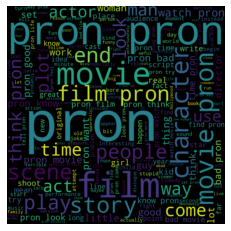

In [34]:
comment_words = ''
for val in df_train[df_train['Label'] == 0].Text: 
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud(comment_words)

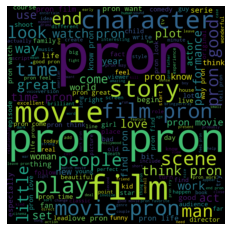

In [35]:
comment_words = ''
for val in df_train[df_train['Label'] == 1].Text: 
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
wordcloud(comment_words)

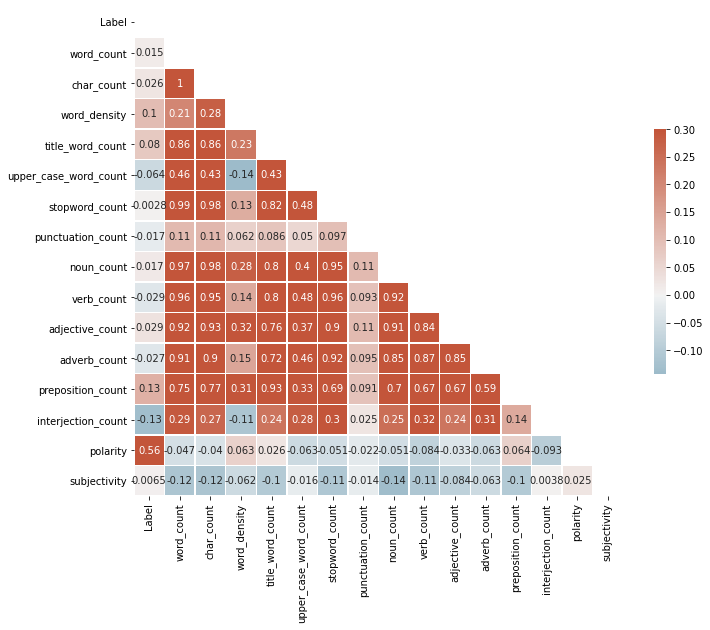

In [32]:
corr = df_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot = True, cbar_kws={"shrink": .5})

<div class="alert alert-block alert-warning">

We see some features are coorelated which won't affect our model as it is classification task but most important relation is "Polarity" having strong effect on "Label"

</div>

## Data Wrangling

<div class="alert alert-block alert-danger">
<b>Text Clean:</b> Note we didn't clean the text before. We do it now to remove stopwords and punctuations.
</div>

In [19]:
# Reading in proper format from our mentioned file
df_train = pd.read_pickle(dir + '/train_features.pkl')
df_test  = pd.read_pickle(dir + '/test_features.pkl')

In [24]:
# Adding stop word "have" and "not" as they were remove as from in "atestrophe"
STOP_WORDS |= {'ve','nt', 'pron'}

In [25]:
'''
Warangling the data for proper format and normalizing it using lemmatization by removing 
stop words

'''
def normalize(text):

    # Convert the text to lower format
    text = text.lower()

    # Tokenise the text
    text = nlp(text)

    # Appending after lemmatizing
    lemmatized = list()

    # Iterate through each text
    for word in text:
        # Remove punctuations and spaces
        if word.pos_ not in ["PUNCT","SPACE"]:
            lemma = word.lemma_
            # Check for STOP_WORDS
            if lemma and lemma not in STOP_WORDS :
                    lemmatized.append(lemma)

    # Return the final sents
    return " ".join(lemmatized)

In [26]:
%%time
# Apply the functions
df_train['Text'] = df_train['Text'].apply(normalize)
df_test['Text']  = df_test['Text'].apply(normalize)

CPU times: user 43min 11s, sys: 6.24 s, total: 43min 18s
Wall time: 43min 20s


<div class="alert alert-block alert-danger">
<b>Features:</b> Writing files again to avoid crashing of RAM.
</div>

In [27]:
# Saving once again with removed stopwords to avoid memory crash
df_train.to_pickle(dir + "/train_features.pkl")
df_test.to_pickle(dir + "/test_features.pkl")

## TF-IDF vectorization

We use the TF-ID vectorization here to tokenise the texts and generate features out of it. The point to be noted here is we only generate features for fixed set of words in the corpus as beyond that it generally doesn't adds much of information.

**Note:** For our purpose we use maximum features = 100 and max_df = 1.00 which corresponds to ignore all words which are present in 100% of texts. We use bigrams here too.



In [28]:
# Reading in proper format from our mentioned file
df_train = pd.read_pickle(dir + '/train_features.pkl')
df_test  = pd.read_pickle(dir + '/test_features.pkl')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#Tfidf vectorizer
tv = TfidfVectorizer(max_features=100,max_df = 1.00, ngram_range=(1,2))

In [ ]:
%%time
#transformed train reviews
tv_train_reviews = tv.fit_transform(df_train['Text'])

#transformed test reviews
tv_test_reviews = tv.transform(df_test['Text'])

CPU times: user 17.2 s, sys: 397 ms, total: 17.6 s
Wall time: 17.6 s


## Cleaned files

In [ ]:
df1 = pd.DataFrame(tv_train_reviews.toarray(), columns=tv.get_feature_names()).add_prefix('TFIDF_')

# Appending it to df for feature mapping
df = pd.concat([df_train, df1], axis=1)

# Storing it as pickle
df.to_pickle(dir + '/train_tfid_features.pkl')

In [ ]:
df1 = pd.DataFrame(tv_test_reviews.toarray(), columns=tv.get_feature_names()).add_prefix('TFIDF_')

# Appending it to df for feature mapping
df = pd.concat([df_test, df1], axis=1)

# Storing it as pickle
df.to_pickle(dir + '/test_tfid_features.pkl')

Let's go to the following [file](https://colab.research.google.com/drive/1ZUmQqK1-NpDvntNaY7Hkvsss4msWMCC8?usp=sharing) for decriptive statistics